<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/getting_proteomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [8]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Read fasta ###

def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.

  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

Loading Tempura dataset

In [3]:
# tempura = pd.read_csv('/content/200617_TEMPURA.csv')
# tempura = pd.read_csv('/content/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [4]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Loading all_proteins

In [5]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins_filtered = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
all_proteins_rapid = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)

Loading RAPID_disorder values

In [ ]:
# rapid_disorder_values = pd.read_csv('RAPID_disorder_values.csv', index_col=0)

## Getting UniProt IDs

Tepura has NCBI taxonomy IDs, but we need UniProt proteome IDs. We can get them using UniProt REST API search

In [ ]:
uniprot_jsons = []
failures = []

# loop through the taxonomy IDs and retrieve proteome data
for tax_id in tqdm(tempura['taxonomy_id']):
  # define the UniProt API URL
  url = f'https://rest.uniprot.org/proteomes/stream?format=json&query=%28%28taxonomy_id%3A{tax_id}%29%29'
  # send an HTTP GET request to the UniProt API
  response = requests.get(url)
  # Check if the request was successful
  if response.status_code == 200:
    # save JSON
    uniprot_jsons.append(response.json())
  else:
    failures.append(tax_id)
    uniprot_jsons.append({})

100%|██████████| 893/893 [08:24<00:00,  1.77it/s]


In many cases we get mre than one search result for one taxonomy ID. We need to check each search result and only keep the UniProt ID that has the same taxonomy ID as Tempura

In [ ]:
# initiate empty list to save UniProt IDs
uniprot_ids = []

# iterate through JSON results
for i, jsn in enumerate(uniprot_jsons):
  # get results
  results = jsn['results']
  # get candidate UniProt IDs and corresponding taxonomy IDs
  u_ids = [r['id'] for r in results]
  t_ids = [r['taxonomy']['taxonId'] for r in results]
  # make a dictionary of candidate IDs
  results_dict = {k:v for k, v in zip(t_ids, u_ids)}
  # get actual taxonomy ID
  taxonomy_id = tempura.loc[i, 'taxonomy_id']
  # save correct UniProt ID
  try:
    uniprot_ids.append(results_dict[taxonomy_id])
  except:
    # no correct ID found
    uniprot_ids.append(None)

We can now drop any Tempura rows with no available UniProt IDs and store the result

In [ ]:
tempura['uniprot_id'] = uniprot_ids

In [ ]:
tempura.dropna(subset='uniprot_id', inplace=True)

In [ ]:
tempura.reset_index(drop=True, inplace=True)

In [ ]:
tempura.to_csv('tempura_bacteria_uniprot.csv')

## Downloading UniProt proteomes

In [ ]:
!mkdir proteomes

In [ ]:
tempura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   genus_and_species      680 non-null    object 
 1   taxonomy_id            680 non-null    int64  
 2   strain                 680 non-null    object 
 3   superkingdom           680 non-null    object 
 4   phylum                 680 non-null    object 
 5   class                  678 non-null    object 
 6   order                  673 non-null    object 
 7   family                 662 non-null    object 
 8   genus                  675 non-null    object 
 9   assembly_or_accession  680 non-null    object 
 10  Genome_GC              651 non-null    float64
 11  Genome_size            680 non-null    float64
 12  16S_accssion           680 non-null    object 
 13  16S_GC                 680 non-null    float64
 14  Tmin                   680 non-null    float64
 15  Topt_a

In [ ]:
failures = []

for i in tqdm(tempura.index):
  # make file path and get UniProt ID
  species = tempura.loc[i, 'genus_and_species'].replace(' ', '_')
  fasta_file_path = f'/content/proteomes/{species}.fasta'
  id = tempura.loc[i, 'uniprot_id']
  # define the UniProt API URL to retrieve FASTA data
  url = f'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28%28proteome%3A{id}%29%29'
  # send an HTTP GET request to the UniProt API to get FASTA data
  response = requests.get(url)
  # check if the request was successful
  if response.status_code == 200:
    # save the FASTA data to a file
    with open(fasta_file_path, 'w') as fasta_file:
      fasta_file.write(response.text)
  else:
    failures.append(id)

100%|██████████| 680/680 [56:33<00:00,  4.99s/it]


In [ ]:
failures

[]

In [ ]:
!zip -r /content/proteomes.zip /content/proteomes -i '*.fasta'
from google.colab import files
files.download('/content/proteomes.zip')

## Creating a DataFrame with all sequences

In [ ]:
all_proteins = pd.DataFrame(columns=['ID', 'Sequence', 'Length', 'Species'])

In [ ]:
for species in tqdm(tempura['genus_and_species']):
  filename = species.replace(' ', '_') + '.fasta'
  df = read_fasta(f'/content/proteomes/{filename}')
  df['Species'] = species
  all_proteins = pd.concat([all_proteins, df], ignore_index=True)

100%|██████████| 680/680 [01:02<00:00, 10.87it/s]


In [ ]:
all_proteins.to_csv('all_proteins.csv')

Filtering to only keep species with at least 1000 proteins

In [ ]:
# group the DataFrame by the 'species' column and count the number of records for each species
species_counts = all_proteins['Species'].value_counts()
# filter the species with more than 1000 records
selected_species = species_counts[species_counts >= 1000].index
# create a new DataFrame that only includes the selected species
all_proteins_filtered = all_proteins[all_proteins['Species'].isin(selected_species)].reset_index(drop=True)

Remove species that don't have 1000 records from Tempura

In [ ]:
tempura = tempura[tempura['genus_and_species'].isin(selected_species)].reset_index(drop=True)

In [ ]:
tempura.to_csv('tempura_filtered.csv')

Saving combined FASTA files for disorder calculations

In [ ]:
!mkdir /content/combined_fastas

In [ ]:
# define the maximum sequences per file
max_sequences_per_file = 75000

# split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
for i, chunk in enumerate(range(0, len(all_proteins_filtered), max_sequences_per_file)):
  chunk_df = all_proteins_filtered.iloc[chunk:chunk + max_sequences_per_file]
  # create a FASTA file for the chunk
  fasta_file_path = f'/content/combined_fastas/output_{i+1}.fasta'
  with open(fasta_file_path, 'w') as fasta_file:
    for _, row in chunk_df.iterrows():
      id = row['ID']
      seq = row['Sequence']
      fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
!zip -r /content/combined_fastas.zip /content/combined_fastas -i '*.fasta'
from google.colab import files
files.download('/content/combined_fastas.zip')

  adding: content/combined_fastas/output_9.fasta (deflated 43%)
  adding: content/combined_fastas/output_12.fasta (deflated 43%)
  adding: content/combined_fastas/output_10.fasta (deflated 43%)
  adding: content/combined_fastas/output_4.fasta (deflated 43%)
  adding: content/combined_fastas/output_2.fasta (deflated 43%)
  adding: content/combined_fastas/output_5.fasta (deflated 43%)
  adding: content/combined_fastas/output_3.fasta (deflated 43%)
  adding: content/combined_fastas/output_8.fasta (deflated 43%)
  adding: content/combined_fastas/output_1.fasta (deflated 43%)
  adding: content/combined_fastas/output_6.fasta (deflated 43%)
  adding: content/combined_fastas/output_16.fasta (deflated 43%)
  adding: content/combined_fastas/output_7.fasta (deflated 43%)
  adding: content/combined_fastas/output_13.fasta (deflated 43%)
  adding: content/combined_fastas/output_17.fasta (deflated 43%)
  adding: content/combined_fastas/output_11.fasta (deflated 43%)
  adding: content/combined_fastas/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Combining partial RAPID results and loading into all_proteins

In [ ]:
rapid_disorder_values = pd.DataFrame(columns = ['Prot. ID', 'Disorder Content %'])

In [ ]:
# set number of csv files with partial RAPID calculation results
n = 17
# iterate through each file and concatenate to all_proteins_filtered
for i in tqdm(range(n)):
  # make filename with addition of '0' if 1-9
  if i+1 < 10:
    filename = f'0{i+1}.csv'
  else:
    filename = f'{i+1}.csv'
  # read csv with RAPID result
  rapid_result = pd.read_csv(filename)
  rapid_result = rapid_result[['Prot. ID', 'Disorder Content %']]
  # append RAPID disorder prediciton to overall dataframe
  rapid_disorder_values = pd.concat([rapid_disorder_values, rapid_result], axis=0)

100%|██████████| 17/17 [00:07<00:00,  2.26it/s]


In [ ]:
rapid_disorder_values.to_csv('RAPID_disorder_values.csv')

Appending RAPID disorder values to all_proteins_filtered

In [ ]:
rapid_disorder_values

,Prot. ID,Disorder Content %
0,A0A172T110,5.91
1,A0A172T128,7.07
2,A0A172T1X5,1.55
3,A0A172T2F9,1.90
4,A0A172T439,6.52
...,...,...
10355,A0A2K8L2B0,4.35
10356,A0A2K8L2C4,8.43
10357,A0A2K8L2D9,15.89
10358,A0A2K8L2F7,10.10


In [ ]:
all_proteins_rapid = all_proteins_filtered.join(rapid_disorder_values.set_index('Prot. ID'),
                                                   on='ID', how='inner')

In [ ]:
all_proteins_rapid['RAPID_disorder'] = all_proteins_rapid['Disorder Content %'] / 100
all_proteins_rapid.drop('Disorder Content %', axis=1, inplace=True)

all_proteins_rapid['RAPID_fully_disordered'] = all_proteins_rapid['RAPID_disorder'] >= 0.5
all_proteins_rapid['RAPID_n_disordered_residues'] = all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length']

In [41]:
all_proteins_rapid.to_csv('all_proteins_rapid.csv')

## NEXT

In [40]:
all_proteins_rapid.columns

Index(['ID', 'Sequence', 'Length', 'Species', 'RAPID_disorder',
       'RAPID_fully_disordered', 'RAPID_n_disordered_residues'],
      dtype='object')

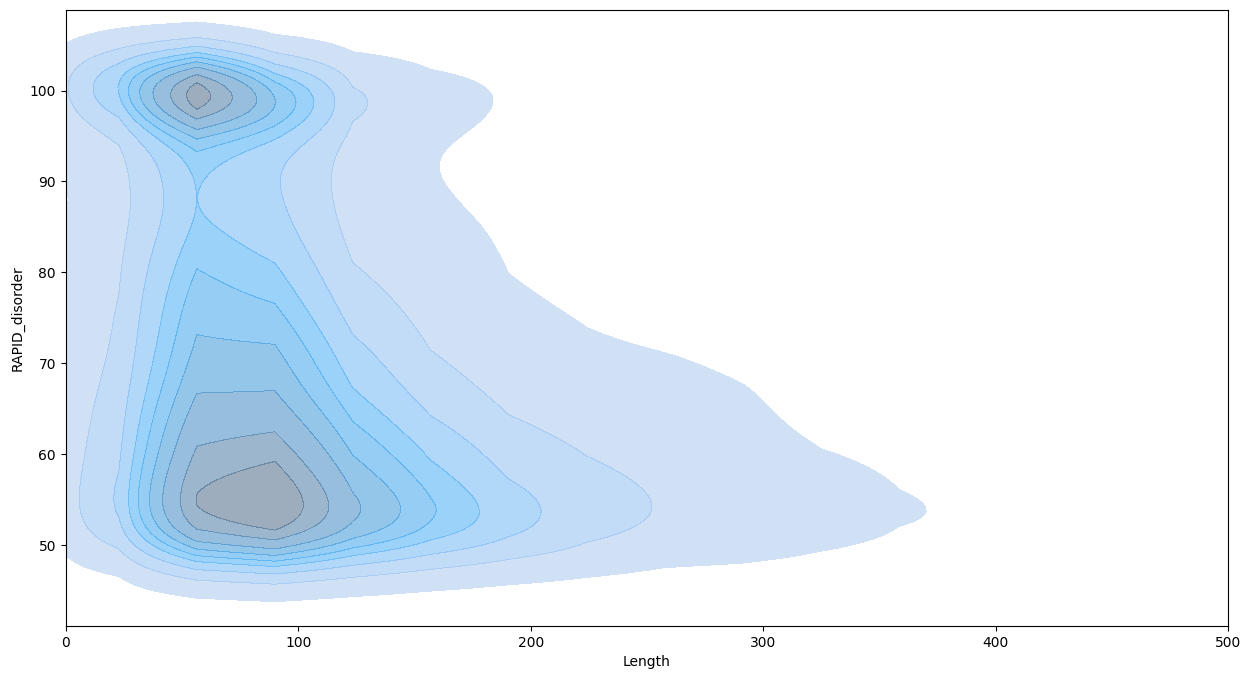

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.kdeplot(data=all_proteins_rapid[all_proteins_rapid['RAPID_fully_disordered']],
                x='Length', y='RAPID_disorder', alpha=0.5, fill=True, ax=ax)
ax.set_xlim(0, 500)
fig.show()

In [46]:
species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder', 'RAPID_fully_disordered']]

<ipython-input-46-ba1d37d7f8ba>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder', 'RAPID_fully_disordered']]


In [51]:
tempura = tempura.join(species_rapid_disorder, how='inner', on='genus_and_species', )

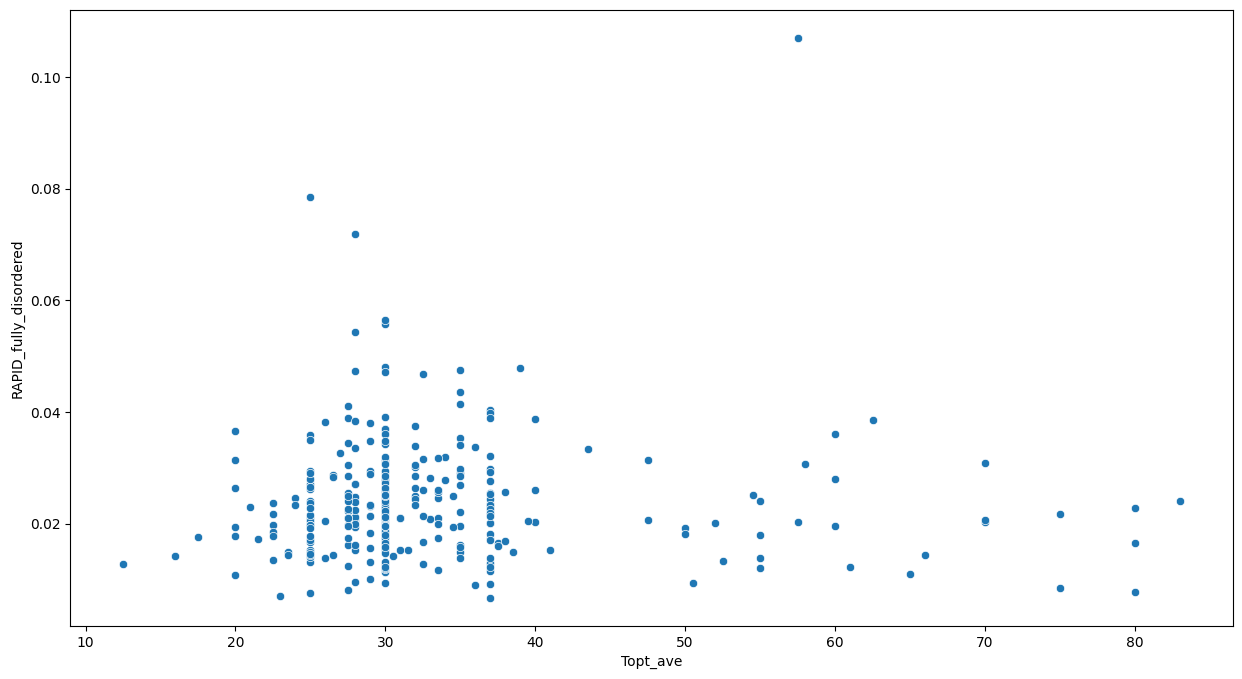

In [58]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(data=tempura, x='Topt_ave', y='RAPID_fully_disordered', ax=ax)

fig.show()